In [95]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm, notebook
from glob import glob
from itertools import chain
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(f"Tenorflow version : {tf.__version__}")

Tenorflow version : 2.14.0


In [2]:
# setting size parameters of the images
im_width = 256
im_height = 256

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/Datasets/brain_mri_segmentatiaon.zip"

In [5]:
!unzip "/content/drive/MyDrive/Datasets/brain_mri_segmentatiaon.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [68]:
image_filenames_train = []

# creating list of all files containing the word "mask"
mask_files = glob('/content/kaggle_3m/*/*_mask*')

for i in mask_files:
  image_filenames_train.append(i.replace('_mask',''))

image_filenames_train[:10]

['/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_10.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_9.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_40.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_37.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_49.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_21.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_48.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41.tif',
 '/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_17.tif']

In [69]:
len(image_filenames_train)

3929

In [70]:
# Plotting some images and corresponding masks
def plot_from_img_path(rows, columns, list_img_path):
  fig = plt.figure(figsize=(6,6))
  for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    img_path = list_img_path[i-1]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    plt.imshow(image)
  plt.show()

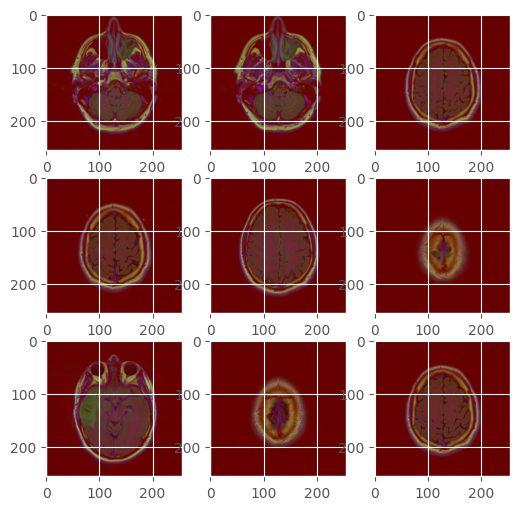

In [71]:
plot_from_img_path(3, 3, image_filenames_train)

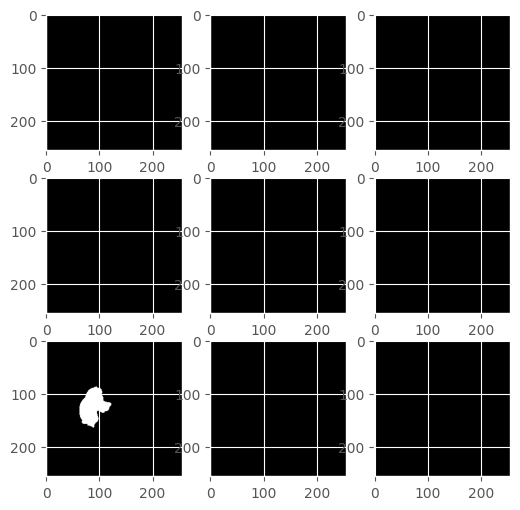

In [72]:
plot_from_img_path(3, 3, mask_files)

In [73]:
data = pd.DataFrame({"image_filenames_train":image_filenames_train, "mask" : mask_files})
data.head()

,image_filenames_train,mask
0,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...
1,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...
2,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...
3,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...
4,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...,/content/kaggle_3m/TCGA_FG_7637_20000922/TCGA_...


In [74]:
df_train, df_test = train_test_split(data, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.2)

len(df_train), len(df_val), len(df_test)

(2828, 708, 393)

In [75]:
# Datagenerator and augmentation
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask) # values for each batch not a single return

In [76]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

### Dice loss

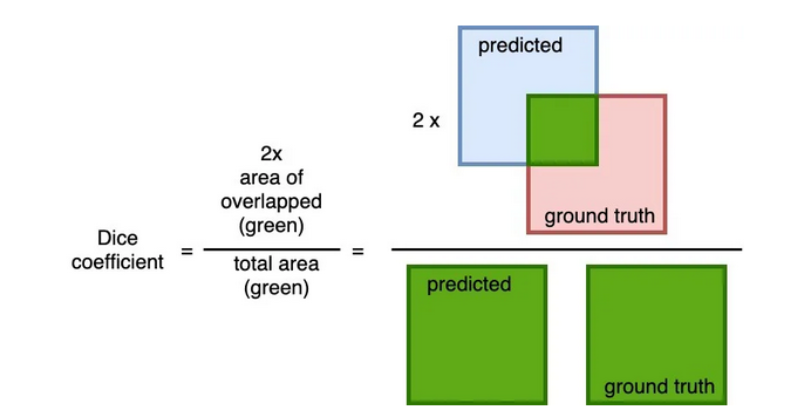

Or numerically,

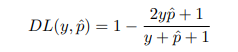

In [77]:
def dice_coefficients(y_true, y_pred, smooth=100):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)

  intersection = K.sum(y_true_flatten * y_pred_flatten)
  union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)

  return (2 * intersection + smooth) / (union + smooth)

In [78]:
def dice_coefficients_loss(y_true, y_pred, smooth=100):
  return 1-dice_coefficients(y_true, y_pred, smooth)

In [79]:
def iou(y_true, y_pred, smooth=100):
  intersection = K.sum(y_true * y_pred)
  sum_ = K.sum(y_true + y_pred)
  iou = (intersection + smooth) / (sum_ - intersection + smooth)
  return iou

In [80]:
def jaccard_distance(y_true, y_pred, smooth=100):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)

  return 1-iou(y_true_flatten, y_pred_flatten)

##### Unet implementation

In [81]:

def unet(input_size=(256, 256, 3)):
    """
    This function creates and returns a U-Net model. U-Net is a type of convolutional neural network
    designed for fast and precise segmentation of images. It consists of a contracting (downsampling)
    path and an expansive (upsampling) path, which gives it a U-shaped architecture.

    Parameters:
    -----------
    input_size : tuple of int
        The size of the input images. It is a 3-tuple for (height, width, channels).
        Default is (256, 256, 3).

    Returns:
    --------
    model : keras.models.Model
        The constructed U-Net model.
    """
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### Building the model

In [82]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [83]:
# calling the model and viewing the architecture
model = unet()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 256, 256, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 activation_72 (Activation)  (None, 256, 256, 64)         0         ['conv2d_76[0][0]']           
                                                                                                  
 conv2d_77 (Conv2D)          (None, 256, 256, 64)         36928     ['activation_72[0][0]']       
                                                                                            

In [84]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [85]:
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

In [86]:
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [87]:
# setting input_image shape for model
model = unet(input_size=(im_height, im_width, 3))

In [88]:
# the optimizer
optimizer = Adam(learning_rate=learning_rate)

In [89]:
# compiling the model
model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

In [90]:
# fitting the model on training data
callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
89/88 [==============================] - ETA: -1s - loss: 0.8706 - binary_accuracy: 0.9297 - iou: 0.0707 - dice_coefficients: 0.1288Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.97659, saving model to unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 174s 2s/step - loss: 0.8706 - binary_accuracy: 0.9297 - iou: 0.0707 - dice_coefficients: 0.1288 - val_loss: 0.9766 - val_binary_accuracy: 0.9827 - val_iou: 0.0121 - val_dice_coefficients: 0.0238
Epoch 2/50
89/88 [==============================] - ETA: -1s - loss: 0.7783 - binary_accuracy: 0.9870 - iou: 0.1267 - dice_coefficients: 0.2220
Epoch 2: val_loss improved from 0.97659 to 0.95598, saving model to unet.hdf5
88/88 [==============================] - 170s 2s/step - loss: 0.7783 - binary_accuracy: 0.9870 - iou: 0.1267 - dice_coefficients: 0.2220 - val_loss: 0.9560 - val_binary_accuracy: 0.9912 - val_iou: 0.0235 - val_dice_coefficients: 0.0454
Epoch 3/50
89/88 [==============================] - ETA: -1s - loss: 0.7187 - binary_accuracy: 0.9898 - iou: 0.1664 - dice_coefficients: 0.2812
Epoch 3: val_loss did not improve from 0.95598
88/88 [==============================] - 168s 2s/step - loss: 0.7187 - binary_accuracy: 0.9898 - iou: 0.1664 - dice

### Evaluating the model performance

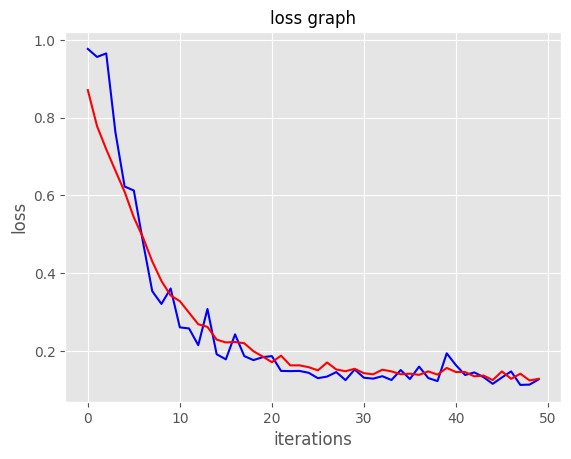

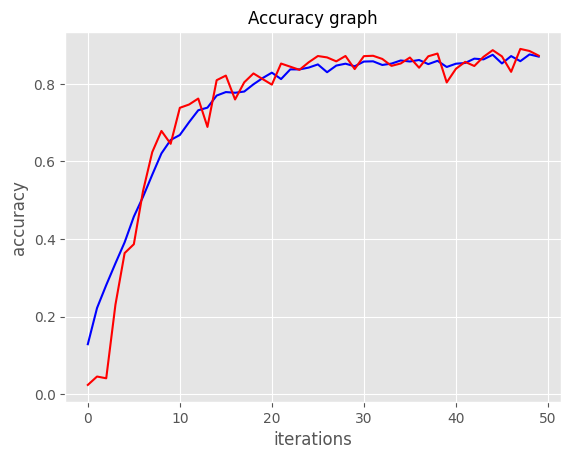

In [94]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

### Visualizing the previously trained model

In [96]:
model = load_model("/content/unet.hdf5", custom_objects={'dice_coefficients_loss':dice_coefficients_loss,
                                                         "iou":iou,
                                                         "dice_coefficients":dice_coefficients})

In [97]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 11s 850ms/step - loss: 0.1078 - binary_accuracy: 0.9977 - iou: 0.8077 - dice_coefficients: 0.8929
Test Loss  0.10782000422477722
Test IoU  0.9976639151573181
Test Dice Coefficient  0.807662308216095


1/1 [==============================] - 0s 22ms/step


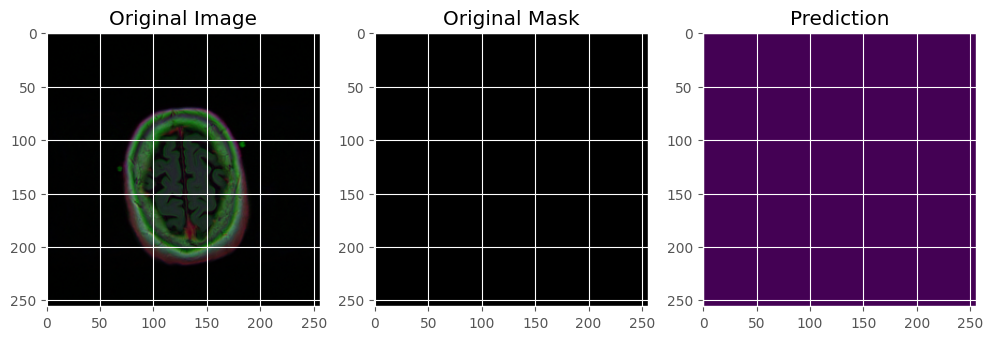

1/1 [==============================] - 0s 19ms/step


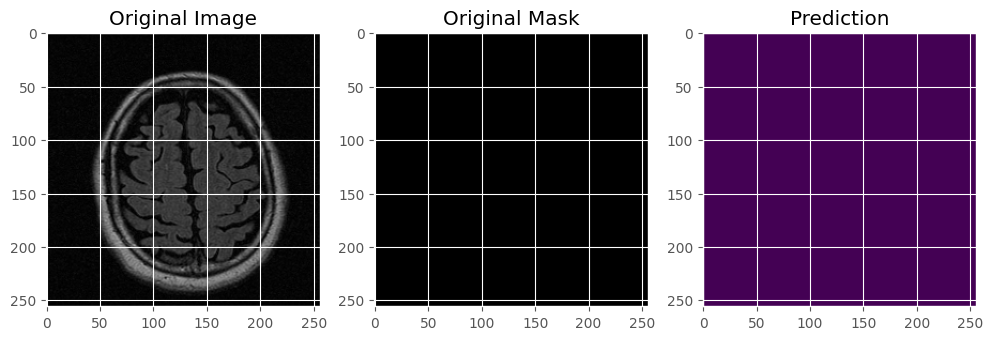

1/1 [==============================] - 0s 19ms/step


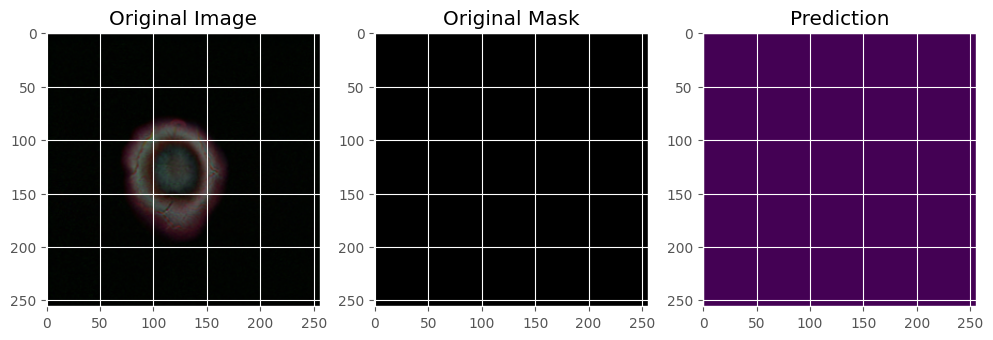

1/1 [==============================] - 0s 20ms/step


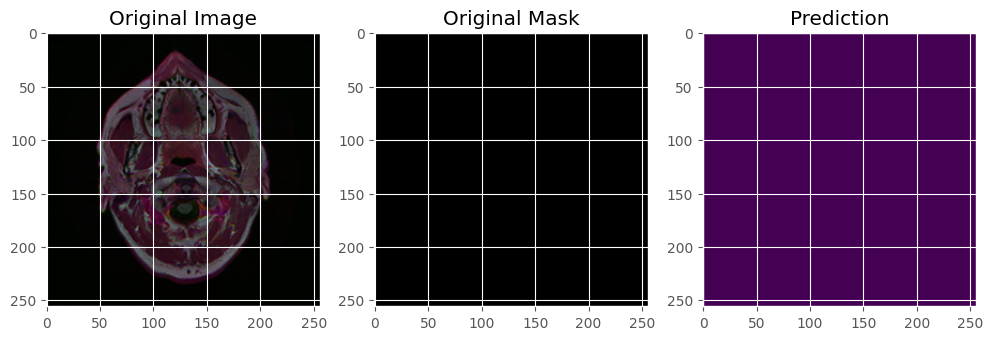

1/1 [==============================] - 0s 20ms/step


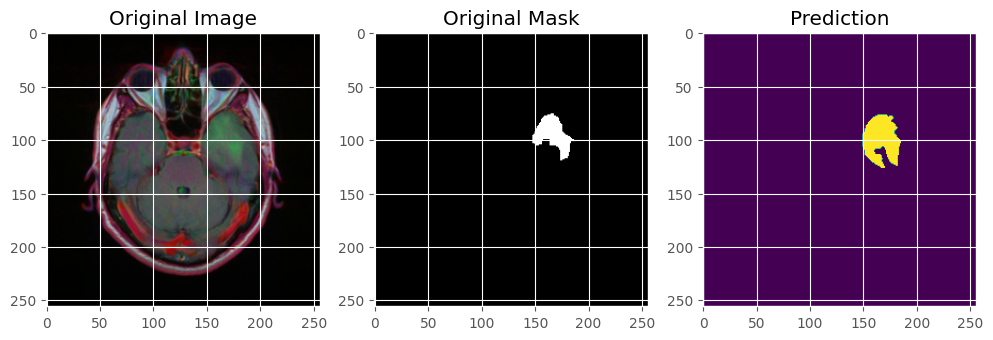

1/1 [==============================] - 0s 22ms/step


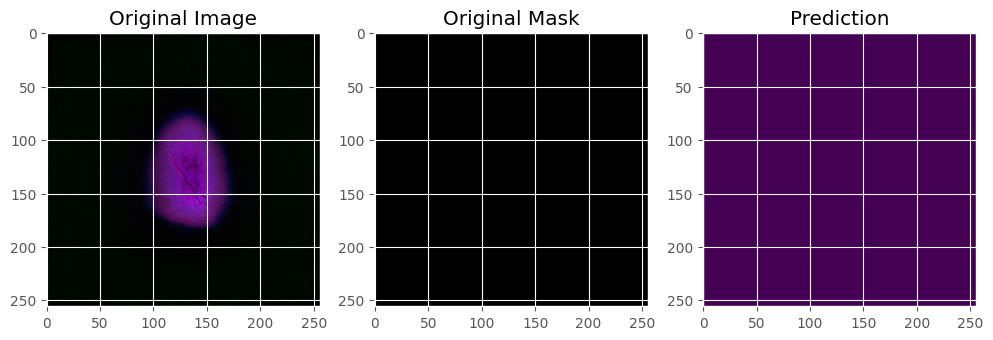

1/1 [==============================] - 0s 24ms/step


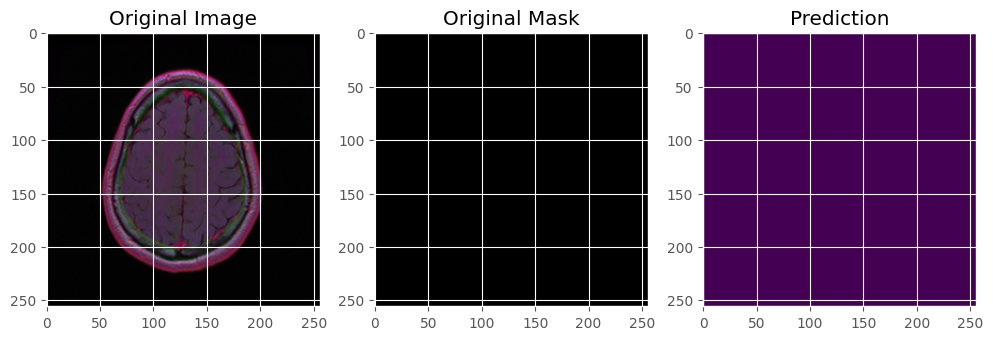

1/1 [==============================] - 0s 23ms/step


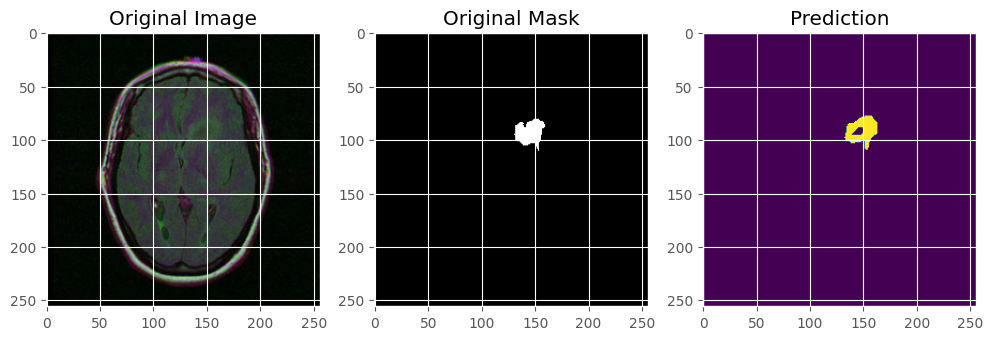

1/1 [==============================] - 0s 20ms/step


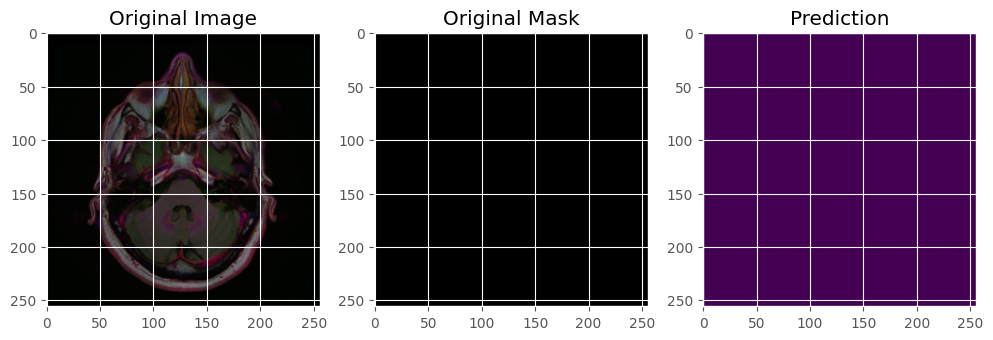

1/1 [==============================] - 0s 19ms/step


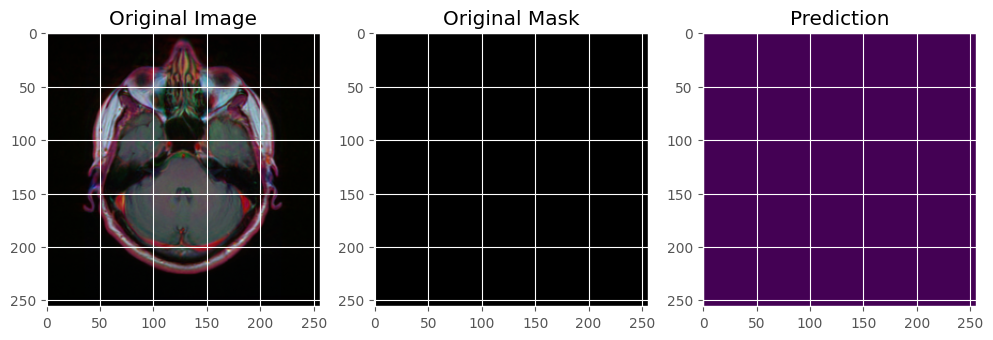

1/1 [==============================] - 0s 20ms/step


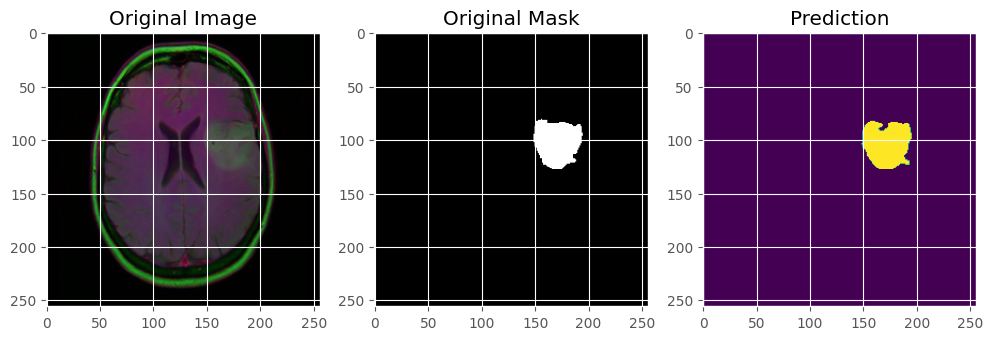

1/1 [==============================] - 0s 29ms/step


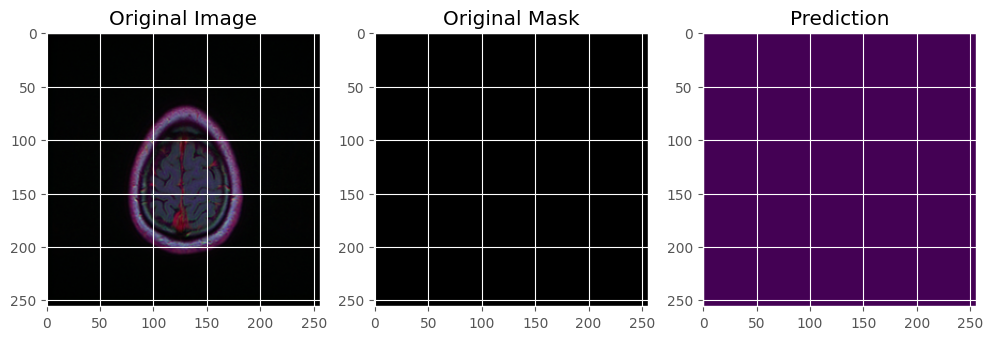

1/1 [==============================] - 0s 49ms/step


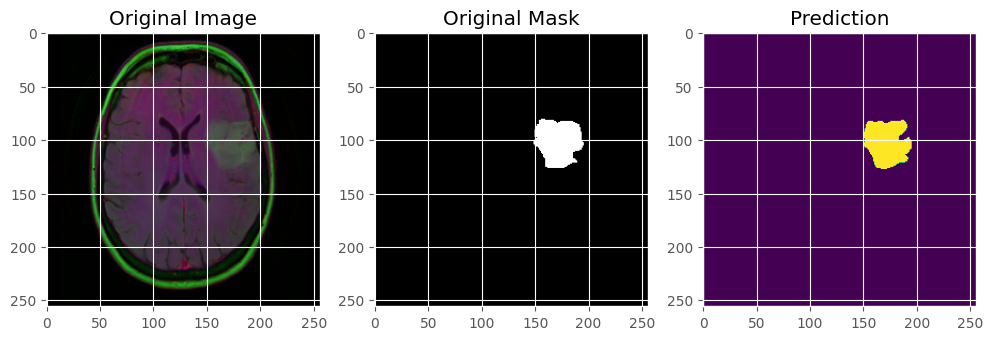

1/1 [==============================] - 0s 31ms/step


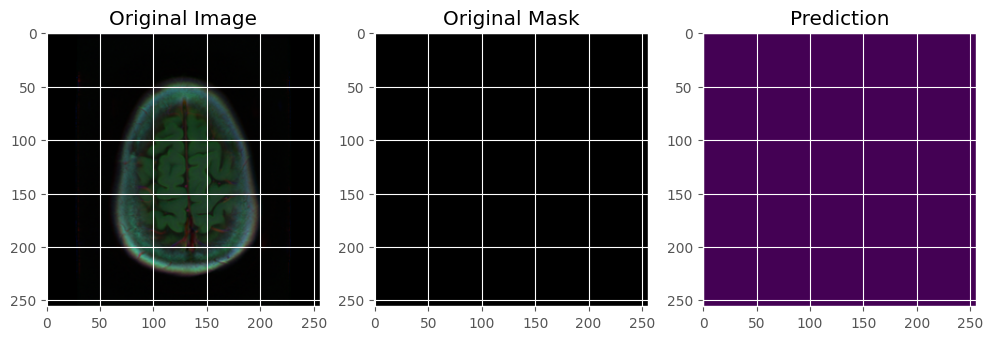

1/1 [==============================] - 0s 29ms/step


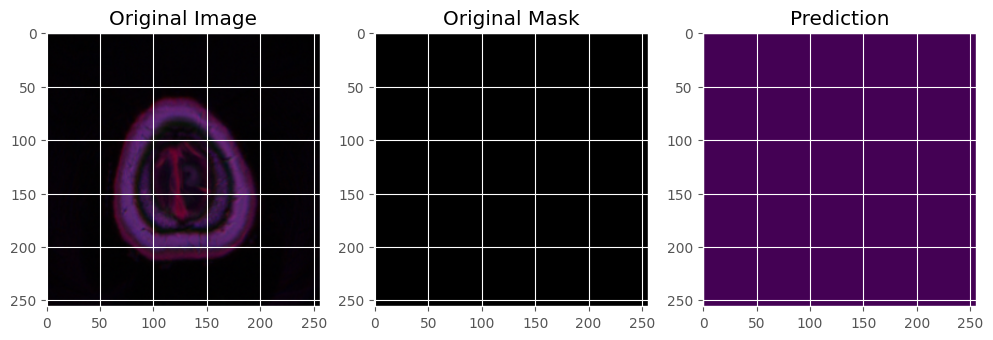

1/1 [==============================] - 0s 29ms/step


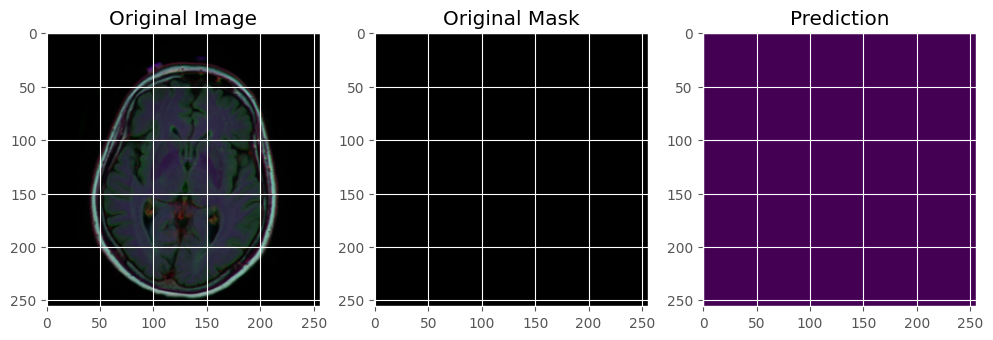

1/1 [==============================] - 0s 38ms/step


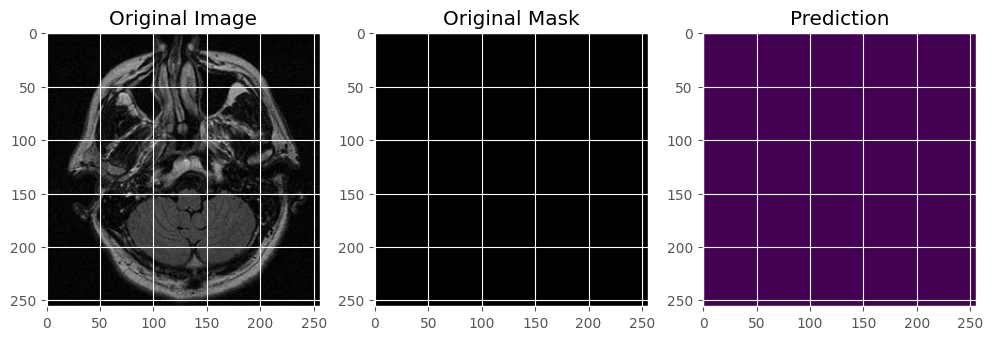

1/1 [==============================] - 0s 25ms/step


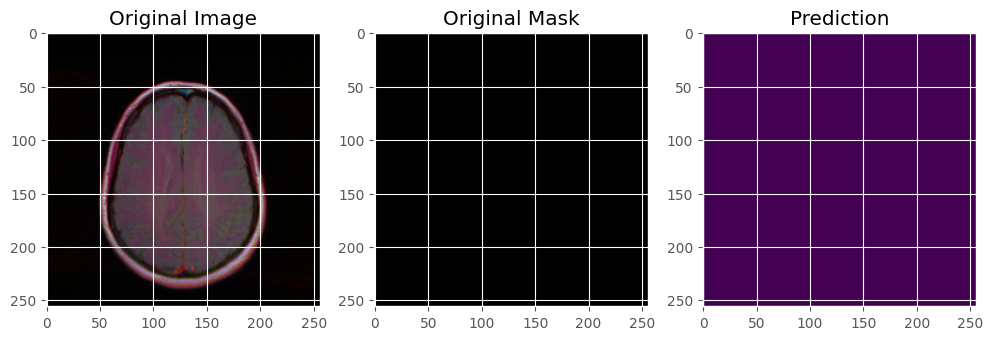

1/1 [==============================] - 0s 20ms/step


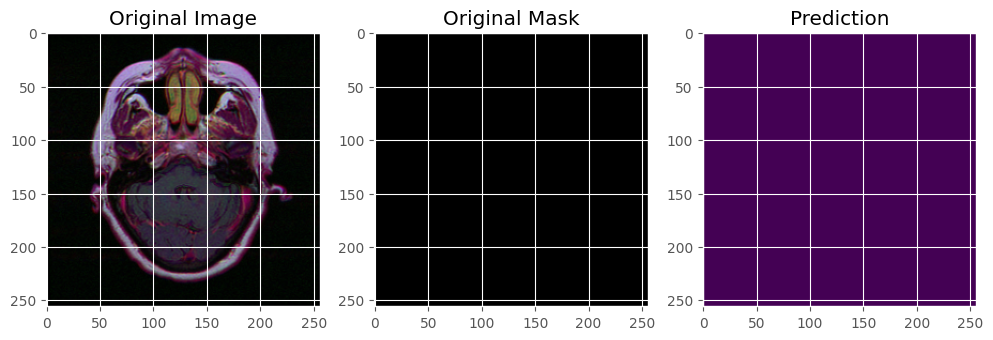

1/1 [==============================] - 0s 29ms/step


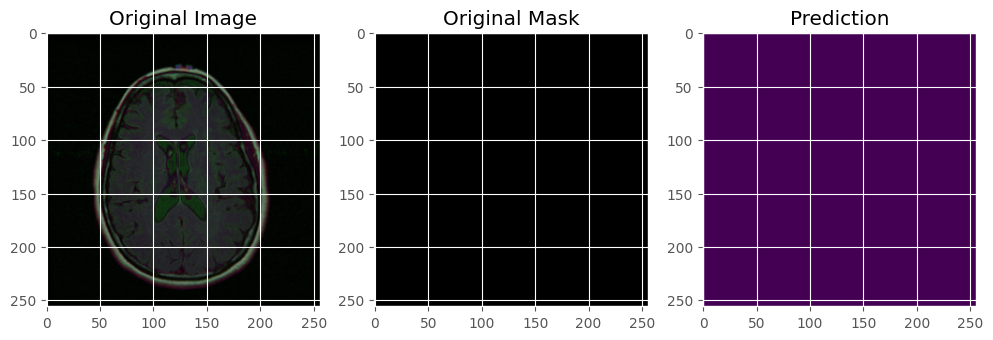

In [102]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5)
    plt.title('Prediction')
    plt.show()